# Descripción del sistema
El sistema consiste en el desarrollo de 5 gráficos diferentes, estos gráficos son realizados con dos conjuntos de datos de dos entidades costarricenses diferentes que son el INEC y el OIJ, ambos conjuntos de datos fueron descargados en formato csv y son almacenados como dataframes utilizando la función de spark en python, además de estos los datos son limpiados ya que tienen incongruencias en su formato, una vez con los datos limpios se envían los mismo a postgres y se grafican

In [1]:
#Bibliotecas necesarias para el uso de spark
from pyspark.sql import SparkSession
from pyspark.files import SparkFiles
from pyspark.sql import functions as F
from pyspark.sql.functions import col, unix_timestamp, to_date , regexp_replace

In [2]:
#Se guardan ambos archivos como dataframes
oij_csv=spark.read.format("csv").option("header","true").option("inferSchema","true").load("Estadisticas.csv")
inec_csv=spark.read.format("csv").option("header","true").option("inferSchema","true").load("reempleocenso2011-22.csv")

In [3]:
#Se imprimen ambos esquemas para observar el formato en el que vienen los datos, esto servirá para ajustar
#el dataframe a lo que necesitemos
#este de abajo será el formato del OIJ
oij_csv.printSchema()
oij_csv.show()

root
 |-- Delito: string (nullable = true)
 |-- SubDelito: string (nullable = true)
 |-- Fecha: string (nullable = true)
 |-- Hora: string (nullable = true)
 |-- Victima: string (nullable = true)
 |-- SubVictima: string (nullable = true)
 |-- Edad: string (nullable = true)
 |-- Genero: string (nullable = true)
 |-- Nacionalidad: string (nullable = true)
 |-- Provincia: string (nullable = true)
 |-- Canton: string (nullable = true)
 |-- Distrito: string (nullable = true)

+------+-----------+----------+-------------------+-----------+--------------------+-------------+------+------------+----------+------------+-------------+
|Delito|  SubDelito|     Fecha|               Hora|    Victima|          SubVictima|         Edad|Genero|Nacionalidad| Provincia|      Canton|     Distrito|
+------+-----------+----------+-------------------+-----------+--------------------+-------------+------+------------+----------+------------+-------------+
|ASALTO|ARMA BLANCA|2011-01-10|15:00:00 - 17:59:59|  

In [4]:
#Este otro formato correspone al INEC
inec_csv=inec_csv.withColumn('PoblacionMayor15', regexp_replace(col('PoblacionMayor15'), " ", ""))
inec_csv=inec_csv.withColumn('PoblacionMayor15',inec_csv['PoblacionMayor15'].cast("Integer").alias('PoblacionMayor15'))
inec_csv=inec_csv.withColumn('TasaDesempleoAbierto',inec_csv['TasaDesempleoAbierto'].cast("double").alias('TasaDesempleoAbierto'))
inec_csv.printSchema()

root
 |-- ProvinciaCantonDistrito: string (nullable = true)
 |-- PoblacionMayor15: integer (nullable = true)
 |-- TasaNetaParticipacion: double (nullable = true)
 |-- TasaOcupacion: double (nullable = true)
 |-- TasaDesempleoAbierto: double (nullable = true)
 |-- PorcentajeEconomicamenteInactivo: double (nullable = true)
 |-- RelacionDependenciaEconomica: double (nullable = true)



In [5]:
#Se registran ambos dataframe como tablas de SQL, esto nos permite realizar consultas sql por medio de sqlContext

sqlContext.registerDataFrameAsTable(oij_csv, "oij")
sqlContext.registerDataFrameAsTable(inec_csv, "inec_csv")
inec_csv1= sqlContext.sql("SELECT ProvinciaCantonDistrito, SUM(PoblacionMayor15) PoblacionMayor15, AVG(TasaNetaParticipacion)TasaNetaParticipacion,AVG(TasaOcupacion)TasaOcupacion,AVG(TasaDesempleoAbierto)TasaDesempleoAbierto,AVG(PorcentajeEconomicamenteInactivo)PorcentajeEconomicamenteInactivo, AVG(RelacionDependenciaEconomica)RelacionDependenciaEconomica FROM inec_csv GROUP BY ProvinciaCantonDistrito ")
sqlContext.registerDataFrameAsTable(inec_csv1, "inec")

In [6]:
'''
Entradas: Un entero
Salidas: Un dataframe
Descripción general: Se encarga de validar cual conjunto de datos se debe enviar 
y realiza la consulta SQL correspondiente la cual removerá espacios en blanco
'''
def quitaEspacios(ind):
    #Este if es de validación para enviar datos de INEC o del OIJ
    #por medio de sqlContext se utiliza la función TRIM que acorta todos los espacios en blanco
    #almacenados antes o después de nuestros datos
    if ind == 1:
        return sqlContext.sql("SELECT Delito, SubDelito,Hora, Fecha, Victima, SubVictima, Edad, Genero, Nacionalidad, Provincia,Canton, TRIM(Distrito) as Distrito from oij")
    else:
        return sqlContext.sql("SELECT TRIM(ProvinciaCantonDistrito) AS ProvinciaCantonDistrito, PoblacionMayor15, TasaNetaParticipacion, TasaOcupacion, TasaDesempleoAbierto, PorcentajeEconomicamenteInactivo, RelacionDependenciaEconomica from inec")

In [7]:
#Simplemente se llama a la función con el número entero correspondiente y se registra el nuevo dataframe
#como la tabla almacenada anteriormente en el sistema, esto se aplica para ambos conjuntos de datos
oij = quitaEspacios(1)
sqlContext.registerDataFrameAsTable(oij, "oij")
inec = quitaEspacios(2)
sqlContext.registerDataFrameAsTable(inec, "inec")

In [8]:
'''
Entradas: Un entero
Salidas: Un dataframe
Descripción general: Se encarga de validar cual conjunto de datos se debe enviar 
y realiza la consulta SQL correspondiente la cual pasará los datos a minúscula
'''
def minusculas(ind):
    #Este if es de validación para enviar datos de INEC o del OIJ
    #por medio de sqlContext se utiliza la función LOWER que se encarga de pasar los datos a minúscula
    if ind == 1:
        return sqlContext.sql("SELECT Delito, SubDelito,Hora, Fecha, Victima, SubVictima, Edad, Genero, Nacionalidad, Provincia,Canton, LOWER(Distrito) as Distrito from oij")
    else:
        return sqlContext.sql("SELECT LOWER(ProvinciaCantonDistrito) AS ProvinciaCantonDistrito, PoblacionMayor15, TasaNetaParticipacion, TasaOcupacion, TasaDesempleoAbierto, PorcentajeEconomicamenteInactivo, RelacionDependenciaEconomica from inec")

In [9]:
#Se llama a la función con el número entero correspondiente y se registra el nuevo dataframe
#como la tabla almacenada anteriormente en el sistema, se aplica a ambos conjuntos de datos
oij = minusculas(1)
sqlContext.registerDataFrameAsTable(oij, "oij")
inec = minusculas(2)
sqlContext.registerDataFrameAsTable(inec, "inec")

In [10]:
'''
Entradas: No posee
Salidas: Un dataframe
Descripción general: Se encarga de hacer la consulta sql para mostrar los datos del OIJ
que no coinciden con ningún dato del INEC
'''
def sacaNoExistentes():
    #Esta consulta se encarga de sacar los distintos por medio del uso de DISTINCT que no se encuentren
    #en la consulta realizada a los datos del INEC
    return sqlContext.sql("SELECT DISTINCT(Distrito) FROM oij WHERE NOT EXISTS(SELECT 1 FROM inec WHERE inec.ProvinciaCantonDistrito = oij.Distrito)") 

In [11]:
#Llama a la función y lo almacena como un dataframe nuevo y una tabla nueva
noCoinciden = sacaNoExistentes()
sqlContext.registerDataFrameAsTable(noCoinciden, "noCoincidencias")

In [12]:
#Se muestran los datos que no coincidieron, principalmente fue porque el OIJ utiliza abreviaciones y no usa tildes,
#el INEC no
noCoinciden.show()

+-----------------+
|         Distrito|
+-----------------+
|       rio cuarto|
|     san jeronimo|
|           libano|
|             para|
|            colon|
|         guapiles|
|          guacimo|
|           puraba|
|            cajon|
|            belen|
|belen de nosarita|
|           granja|
|      santa lucia|
|      desconocido|
|      santo tomas|
|           jardin|
|       agua buena|
|         tarcoles|
|          alegria|
|      santa maria|
+-----------------+
only showing top 20 rows



In [13]:
'''
Entradas: No posee
Salidas: Un dataframe
Descripción general: Se encarga de contar los elementos de la tabla de noCoincidencias
estos elementos corresponen a todos aquellos distritos del OIJ que no corresponden a distritos del INEC
'''
def cuentaNoExistentes():
    return sqlContext.sql("SELECT COUNT(*) as num FROM noCoincidencias") 

In [14]:
#Almacena el dataframe con el dato
numNoCoinciden = cuentaNoExistentes()

In [15]:
#Se despliega el número correspondiente
numNoCoinciden.show()
print("Cantidad de registros que no coincidieron: ", noCoinciden.count())

+---+
|num|
+---+
|102|
+---+

Cantidad de registros que no coincidieron:  102


In [35]:
#Se modifican datos del dataframe del INEC para que correspondan a algunos datos del OIJ
#esto se encarga de buscar por columna los datos que tengan almaceanado los nombres de la manera indicada
#luego se modifican por sus correpondientes en el dataframe del OIJ
inec = inec.withColumn("ProvinciaCantonDistrito", F.when(F.col("ProvinciaCantonDistrito")=='pococí','pococi').otherwise(F.col("ProvinciaCantonDistrito")))
inec = inec.withColumn("ProvinciaCantonDistrito", F.when(F.col("ProvinciaCantonDistrito")=='la unión','la union').otherwise(F.col("ProvinciaCantonDistrito")))
inec = inec.withColumn("ProvinciaCantonDistrito", F.when(F.col("ProvinciaCantonDistrito")=='belén','belen').otherwise(F.col("ProvinciaCantonDistrito")))
inec = inec.withColumn("ProvinciaCantonDistrito", F.when(F.col("ProvinciaCantonDistrito")=='león cortés castro','leon cortes').otherwise(F.col("ProvinciaCantonDistrito")))
inec = inec.withColumn("ProvinciaCantonDistrito", F.when(F.col("ProvinciaCantonDistrito")=='san josé','san jose').otherwise(F.col("ProvinciaCantonDistrito")))
#se guarda el dataframe modificado como una tabla
sqlContext.registerDataFrameAsTable(inec, "inec")

In [36]:
#Se integran por medio de un inner join los conjuntos de datos,y se almacenan como un nuevo dataframe
#este dataframe será enviado a postgres
datosIntegrados = sqlContext.sql("SELECT a.Delito, a.SubDelito, a.Hora, a.Fecha, a.Victima, a.SubVictima, a.Edad, a.Genero, a.Nacionalidad, a.Provincia, a.Canton, a.Distrito, b.PoblacionMayor15, b.TasaNetaParticipacion, b.TasaOcupacion, b.TasaDesempleoAbierto, b.PorcentajeEconomicamenteInactivo, b.RelacionDependenciaEconomica FROM oij a INNER JOIN inec b ON a.Distrito = b.ProvinciaCantonDistrito")

In [37]:
datosIntegrados.printSchema()

root
 |-- Delito: string (nullable = true)
 |-- SubDelito: string (nullable = true)
 |-- Hora: string (nullable = true)
 |-- Fecha: string (nullable = true)
 |-- Victima: string (nullable = true)
 |-- SubVictima: string (nullable = true)
 |-- Edad: string (nullable = true)
 |-- Genero: string (nullable = true)
 |-- Nacionalidad: string (nullable = true)
 |-- Provincia: string (nullable = true)
 |-- Canton: string (nullable = true)
 |-- Distrito: string (nullable = true)
 |-- PoblacionMayor15: long (nullable = true)
 |-- TasaNetaParticipacion: double (nullable = true)
 |-- TasaOcupacion: double (nullable = true)
 |-- TasaDesempleoAbierto: double (nullable = true)
 |-- PorcentajeEconomicamenteInactivo: double (nullable = true)
 |-- RelacionDependenciaEconomica: double (nullable = true)



In [38]:
datosIntegrados=datosIntegrados.withColumn('TasaDesempleoAbierto',datosIntegrados['TasaDesempleoAbierto'].cast("float").alias('TasaDesempleoAbierto'))
datosIntegrados=datosIntegrados.withColumn('TasaNetaParticipacion',datosIntegrados['TasaNetaParticipacion'].cast("float").alias('TasaNetaParticipacion'))
datosIntegrados=datosIntegrados.withColumn('TasaOcupacion',datosIntegrados['TasaOcupacion'].cast("float").alias('TasaOcupacion'))
datosIntegrados=datosIntegrados.withColumn('PorcentajeEconomicamenteInactivo',datosIntegrados['PorcentajeEconomicamenteInactivo'].cast("float").alias('PorcentajeEconomicamenteInactivo'))
datosIntegrados=datosIntegrados.withColumn('RelacionDependenciaEconomica',datosIntegrados['RelacionDependenciaEconomica'].cast("float").alias('RelacionDependenciaEconomica'))
datosIntegrados=datosIntegrados.withColumn('Fecha',to_date(unix_timestamp(col('Fecha'), 'yyyy-MM-dd').cast("timestamp")))

In [39]:
datosIntegrados.printSchema()

root
 |-- Delito: string (nullable = true)
 |-- SubDelito: string (nullable = true)
 |-- Hora: string (nullable = true)
 |-- Fecha: date (nullable = true)
 |-- Victima: string (nullable = true)
 |-- SubVictima: string (nullable = true)
 |-- Edad: string (nullable = true)
 |-- Genero: string (nullable = true)
 |-- Nacionalidad: string (nullable = true)
 |-- Provincia: string (nullable = true)
 |-- Canton: string (nullable = true)
 |-- Distrito: string (nullable = true)
 |-- PoblacionMayor15: long (nullable = true)
 |-- TasaNetaParticipacion: float (nullable = true)
 |-- TasaOcupacion: float (nullable = true)
 |-- TasaDesempleoAbierto: float (nullable = true)
 |-- PorcentajeEconomicamenteInactivo: float (nullable = true)
 |-- RelacionDependenciaEconomica: float (nullable = true)



In [40]:
datosIntegrados.show()

+------+-----------+-------------------+----------+-----------+--------------------+-------------+------+------------+----------+-------------+-------------+----------------+---------------------+-------------+--------------------+--------------------------------+----------------------------+
|Delito|  SubDelito|               Hora|     Fecha|    Victima|          SubVictima|         Edad|Genero|Nacionalidad| Provincia|       Canton|     Distrito|PoblacionMayor15|TasaNetaParticipacion|TasaOcupacion|TasaDesempleoAbierto|PorcentajeEconomicamenteInactivo|RelacionDependenciaEconomica|
+------+-----------+-------------------+----------+-----------+--------------------+-------------+------+------------+----------+-------------+-------------+----------------+---------------------+-------------+--------------------+--------------------------------+----------------------------+
|ASALTO|ARMA BLANCA|15:00:00 - 17:59:59|2011-01-10|    PERSONA|MENOR DE EDAD [PE...|Menor de edad|HOMBRE|  COSTA RICA|

In [41]:
spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.1.4.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.1.4.jar") \
    .getOrCreate()

In [42]:
def mandaPostgres(dataframe, nombre):
    dataframe \
        .write \
        .format("jdbc") \
        .mode('overwrite') \
        .option("url", "jdbc:postgresql://localhost/") \
        .option("user", "postgres") \
        .option("password", "password") \
        .option("dbtable", nombre) \
        .save()

In [43]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas

In [44]:
mandaPostgres(datosIntegrados.select("Delito","SubDelito","Hora","Fecha","Victima","SubVictima","Edad","Genero","Nacionalidad","Provincia","Canton","Distrito","PoblacionMayor15","TasaNetaParticipacion","TasaOcupacion","TasaDesempleoAbierto","PorcentajeEconomicamenteInactivo","RelacionDependenciaEconomica"),"prueba")


In [45]:
sqlContext.registerDataFrameAsTable(datosIntegrados,"datosIntegrados")
def top10Distritos():
    return sqlContext.sql("SELECT DISTINCT distrito, COUNT(delito) as Cantidad_Delitos, SUM(tasaocupacion)/COUNT(delito) as Tasa_Ocupacion FROM datosIntegrados group by distrito order by 2 DESC LIMIT 10") 

In [46]:
top10Distritos=top10Distritos()

In [47]:
top10Distritos.show()

+----------+----------------+------------------+
|  distrito|Cantidad_Delitos|    Tasa_Ocupacion|
+----------+----------------+------------------+
|    carmen|            1346| 53.44999885559082|
|san rafael|            1262| 52.58333206176758|
|   liberia|            1108|50.099998474121094|
|  hospital|            1079|53.900001525878906|
|  catedral|            1073|              57.0|
| san pedro|            1011|  49.9571418762207|
|  alajuela|             990|53.400001525878906|
|     uruca|             984|57.349998474121094|
|    quepos|             857|              54.0|
|    merced|             850|              57.0|
+----------+----------------+------------------+



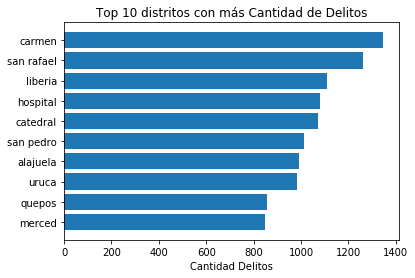

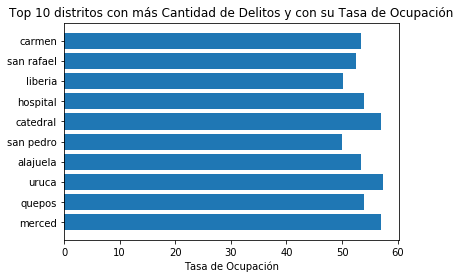

In [56]:
y= top10Distritos.toPandas() ["distrito"].values.tolist()
x= top10Distritos.toPandas() ["Cantidad_Delitos"].values.tolist()
z= top10Distritos.toPandas() ["Tasa_Ocupacion"].values.tolist()
#Obtenemos una lista con las posiciones
y_pos = np.arange(len(y))
#Creamos la grafica pasando los valores en el eje X, Y
plt.barh(y_pos[::-1], x, align='center', alpha=1)
#Añadimos la etiqueta de nombre de cada distrito
plt.yticks(y_pos, y[::-1])
#añadimos una etiqueta en el eje X
plt.xlabel('Cantidad Delitos')
#Y una etiqueta superior
plt.title('Top 10 distritos con más Cantidad de Delitos')
plt.show()

#Obtenemos una lista con las posiciones
y_pos = np.arange(len(y))
#Creamos la grafica pasando los valores en el eje X, Y
plt.barh(y_pos[::-1], z, align='center', alpha=1)
#Añadimos la etiqueta de nombre de cada distrito
plt.yticks(y_pos, y[::-1])
#añadimos una etiqueta en el eje X
plt.xlabel('Tasa de Ocupación')
#Y una etiqueta superior
plt.title('Top 10 distritos con más Cantidad de Delitos y con su Tasa de Ocupación')
plt.show()


In [104]:
def delitosDia():
    return sqlContext.sql("SELECT distrito,COUNT(delito) as Cantidad_Delitos,Fecha, date_format(Fecha, 'EEEE') as Dia_Semana FROM datosIntegrados WHERE distrito='carmen' group by distrito,Fecha") 

In [105]:
delitosDia=delitosDia()

In [106]:
delitosDia.show()

+--------+----------------+----------+----------+
|distrito|Cantidad_Delitos|     Fecha|Dia_Semana|
+--------+----------------+----------+----------+
|  carmen|               6|2011-09-25|    Sunday|
|  carmen|               2|2011-10-09|    Sunday|
|  carmen|              10|2011-09-02|    Friday|
|  carmen|               8|2011-01-22|  Saturday|
|  carmen|               2|2011-05-10|   Tuesday|
|  carmen|               6|2011-06-10|    Friday|
|  carmen|               4|2011-08-26|    Friday|
|  carmen|               4|2011-06-08| Wednesday|
|  carmen|               4|2011-10-22|  Saturday|
|  carmen|               6|2011-06-03|    Friday|
|  carmen|               2|2011-03-07|    Monday|
|  carmen|               4|2011-11-14|    Monday|
|  carmen|              10|2011-10-02|    Sunday|
|  carmen|               8|2011-04-16|  Saturday|
|  carmen|               2|2011-08-17| Wednesday|
|  carmen|               6|2011-07-11|    Monday|
|  carmen|               6|2011-05-24|   Tuesday|


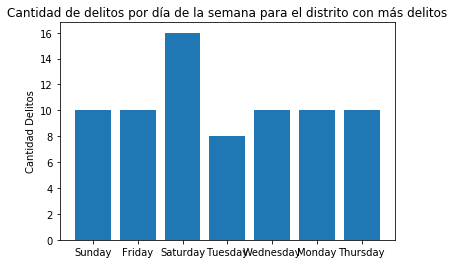

In [107]:
x=delitosDia.toPandas() ["Dia_Semana"].values.tolist()

y= delitosDia.toPandas() ["Cantidad_Delitos"].values.tolist()
 
fig, ax = plt.subplots()
#Colocamos una etiqueta en el eje Y
ax.set_ylabel('Cantidad Delitos')
#Colocamos una etiqueta en el eje X
ax.set_title('Cantidad de delitos por día de la semana para el distrito con más delitos')
#Creamos la grafica de barras utilizando x,y
plt.bar(x, y)
#Finalmente mostramos la grafica con el metodo show()
plt.show()

In [100]:
def delitosTipo():
    return sqlContext.sql("SELECT distrito,COUNT(delito) as Cantidad_Delitos, delito as Tipo_Delito FROM datosIntegrados WHERE distrito='carmen' group by distrito,delito ") 

In [101]:
delitosTipo=delitosTipo()

In [102]:
delitosTipo.show()

+--------+----------------+-----------------+
|distrito|Cantidad_Delitos|      Tipo_Delito|
+--------+----------------+-----------------+
|  carmen|             528|            HURTO|
|  carmen|              84| ROBO DE VEHICULO|
|  carmen|             514|           ASALTO|
|  carmen|             134|             ROBO|
|  carmen|              86|TACHA DE VEHICULO|
+--------+----------------+-----------------+



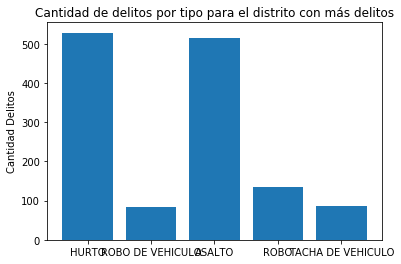

In [103]:
x=delitosTipo.toPandas() ["Tipo_Delito"].values.tolist()

y= delitosTipo.toPandas() ["Cantidad_Delitos"].values.tolist()
 
fig, ax = plt.subplots()
#Colocamos una etiqueta en el eje Y
ax.set_ylabel('Cantidad Delitos')
#Colocamos una etiqueta en el eje X
ax.set_title('Cantidad de delitos por tipo para el distrito con más delitos')
#Creamos la grafica de barras utilizando x,y
plt.bar(x, y)
#Finalmente mostramos la grafica con el metodo show()
plt.show()

In [125]:
def delitosSexo():
    return sqlContext.sql("SELECT genero, COUNT(delito) as Cantidad_Delitos FROM datosIntegrados group by genero order by Cantidad_Delitos DESC") 

In [126]:
delitosSexo=delitosSexo()

In [127]:
delitosSexo.show()

+-----------+----------------+
|     genero|Cantidad_Delitos|
+-----------+----------------+
|     HOMBRE|           26978|
|      MUJER|           11103|
|DESCONOCIDO|             194|
+-----------+----------------+



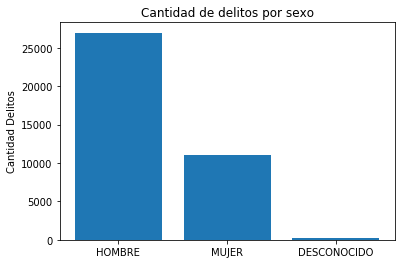

In [130]:
x=delitosSexo.toPandas() ["genero"].values.tolist()

y= delitosSexo.toPandas() ["Cantidad_Delitos"].values.tolist()
 
fig, ax = plt.subplots()
#Colocamos una etiqueta en el eje Y
ax.set_ylabel('Cantidad Delitos')
#Colocamos una etiqueta en el eje X
ax.set_title('Cantidad de delitos por sexo')
#Creamos la grafica de barras utilizando x,y
plt.bar(x, y)
#Finalmente mostramos la grafica con el metodo show()
plt.show()

In [138]:
def subdelitosCant():
    return sqlContext.sql("SELECT Subdelito, COUNT(delito) as Cantidad_Delitos FROM datosIntegrados group by Subdelito ORDER BY Cantidad_Delitos DESC limit 10") 

In [139]:
subdelitosCant=subdelitosCant()

In [140]:
subdelitosCant.show()

+-----------------+----------------+
|        Subdelito|Cantidad_Delitos|
+-----------------+----------------+
|    ARMA DE FUEGO|            6132|
|        FORZADURA|            5897|
|     POR DESCUIDO|            4974|
|TACHA DE VEHICULO|            3534|
|         DESCUIDO|            2325|
|      ARMA BLANCA|            2229|
|    POR CONFIANZA|            2043|
|         ARREBATO|            1111|
|          BOQUETE|            1044|
|  QUITAN CELOSIAS|             957|
+-----------------+----------------+



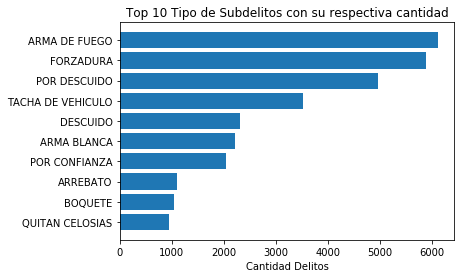

In [142]:
y=subdelitosCant.toPandas() ["Subdelito"].values.tolist()

x= subdelitosCant.toPandas() ["Cantidad_Delitos"].values.tolist()

#Obtenemos una lista con las posiciones
y_pos = np.arange(len(y))
#Creamos la grafica pasando los valores en el eje X, Y
plt.barh(y_pos[::-1], x, align='center', alpha=1)
#Añadimos la etiqueta de nombre de cada distrito
plt.yticks(y_pos, y[::-1])
#añadimos una etiqueta en el eje X
plt.xlabel('Cantidad Delitos')
#Y una etiqueta superior
plt.title('Top 10 Tipo de Subdelitos con su respectiva cantidad')
plt.show()